# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.468421,False,0.250435
1,-1.959243,False,0.549045
2,-0.813138,False,0.619455
3,-1.579307,False,-1.099827
4,-0.678088,False,-1.365518
...,...,...,...
995,1.632999,True,5.673226
996,0.162074,True,2.686286
997,0.640817,False,0.175257
998,0.483879,True,3.462681


<AxesSubplot: xlabel='v0'>

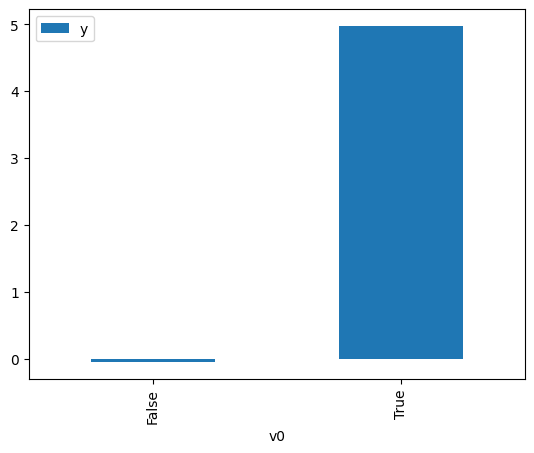

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

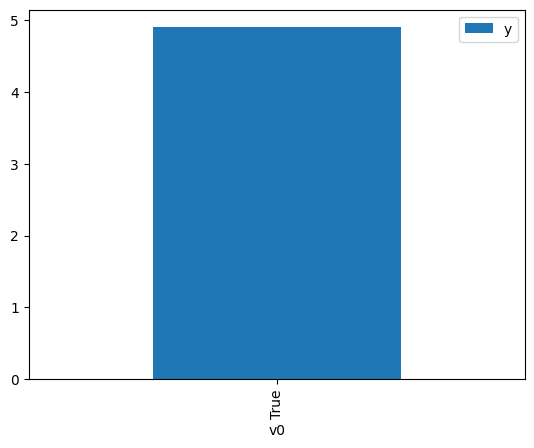

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.777055,False,-0.404053,0.810070,1.234462
1,-1.579336,False,-0.930970,0.949531,1.053151
2,-0.896220,False,1.030578,0.841697,1.188076
3,0.632851,False,1.440769,0.239079,4.182724
4,0.470298,False,0.202821,0.297961,3.356148
...,...,...,...,...,...
995,-0.685311,False,0.028947,0.782576,1.277831
996,-0.634275,False,-0.617439,0.766085,1.305339
997,-1.693956,False,1.202385,0.958776,1.042996
998,0.238732,False,1.734403,0.394448,2.535188


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.667935,True,3.638529,0.043169,23.164936
1,-1.080790,True,4.326058,0.117913,8.480836
2,-0.422474,True,4.949261,0.311199,3.213379
3,0.557194,True,3.637832,0.734539,1.361397
4,-0.001985,True,4.173626,0.495837,2.016792
...,...,...,...,...,...
995,-0.053653,True,4.930507,0.471971,2.118775
996,-0.250217,True,3.790066,0.383230,2.609398
997,1.297640,True,6.231435,0.915872,1.091856
998,0.223724,True,5.863090,0.598901,1.669725


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              3605.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:31:50   Log-Likelihood:                         -1405.0
No. Observations:                1000   AIC:                                      2814.
Df Residuals:                     998   BIC:                                      2824.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1438      0.025      5.821      0.000       0.095       0.192
x2             4.9765      0.059     84.452      0.000       4.861       5.092
==============================================================================
Omnibus:                        5.344   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.362
Skew:                           0.160   Prob(JB):                       0.0685
Kurtosis:                       2.839   Cond. No.                         2.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""